# Generating fake data for neo4j analysis 

## Tasks 

### Intro
- <input type="checkbox" checked> incl motivation & stakeholders
    - stakeholders such as authorities can schedule auditing based on most relevant (central) actors rather than arbitrarily 
- <input type="checkbox" checked> simulationsumgebung

### Simple
- <input type="checkbox" checked> Histogramm: Anzahl data categories pro controller
- <input type="checkbox" checked> Histogramm: Purposes pro controller 
- <input type="checkbox" checked> Histogramm: Rechtsgrundlagen - welche am häufigsten? -> speziell: welche legitimen Interessen?
- <input type="checkbox" checked> Histogramm: Anzahl categories pro purpose

### Intermediate
- <input type="checkbox" checked> Clustering data categories
- <input type="checkbox" checked> "category c wird immer nur auf rechtsgrundlage x verarbeitet" (verteilung der rechtsgrundlagen pro controller )
- <input type="checkbox" checked> category-bezogene ketten / nur ketten von controllers 
    - fake daten datenkategorie wird weitergereicht
    - property auf relationship legen, die die category anzeigt
    - ketten aus gleichen category-relationships anzeigen. 

### Advanced
- <input type="checkbox" checked> Sharing networks / clusters
- <input type="checkbox" checked> Anzahl purposes (pro controller / pro category / pro cluster)
- <input type="checkbox" checked> Netzwerk verändert sich über Zeit (es zentralisiert sich mehr, es clustered sich mehr, ... ) / dynamische Simulationen / horizontal
- <input type="checkbox" checked> "Facebook kauft WhatsApp-Szenarien?"
- <input type="checkbox" checked> "was würde massenhaft data portability von instagram zu tiktok auslösen?"
- <input type="checkbox" checked> "Monopole (nur 1 controller verarbeitet datum x) erkennen"
- <input type="checkbox" checked> Verbraucher:innenfreundlichkeit
- <input type="checkbox" checked> personalized privacy policy/dashboard -> user x kann angeben er/sie nutzt diese drölf dienste -> spuck den relevanten graph aus!
- <input type="checkbox" checked> "besser 1 graph pro person als drölf ds-erklärungen"
--

#### WordNet

Similarities (categories clustern?)


### Tablular vs Graph ML
- compare the clustering algorthims for tabular data (e.g. Gaussian mixture models) with the clustering algorithms for graph data

# Packages

In [3]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import random as rd
from scipy.stats import poisson
import neo4j
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import pickle
from tqdm import tqdm
import networkx as nx

import imageio
import os

from graphdatascience import GraphDataScience

gds = GraphDataScience('bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'))

gds.graph.list()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema


In [4]:
plt.rcParams.update(plt.rcParamsDefault)

plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rc('text', usetex=True)

# Scraping

In [5]:
def get_table(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    elems = []
    for child in soup.find_all('table')[0].children:

        for some in child:
            row = []
            for i,td in enumerate(some):
                try:
                    row.append(td.text.replace('\n',""))
                except:
                    continue
                if len(row) > 0:
                    elems.append(row)

    return elems
    

try:
    table = get_table("https://www.zyxware.com/articles/4344/list-of-fortune-500-companies-and-their-websites")
    subset = [[table[i][1],table[i][3], table[i][5]]   for i in range(0,len(table), 7)]
    fortune_500 = pd.DataFrame(subset[1:], columns=subset[0])
except: 
    print("scrape now broken")
    pass


In [11]:
#fortune_500.to_csv("fortune_500")

fortune_500 = pd.read_csv('fortune_500')

with open ('categories_tilt', 'rb') as fp:
    categories = pickle.load(fp)

with open ('purpose_tilt', 'rb') as fp:
    purpose = pickle.load(fp)

# Using the Python Driver

In [12]:
from neo4j import GraphDatabase

class exampleTilt:

    """
    class:  exampleTilt
    input:  - uri: bolt uri from neo4j
            - auth: credentials for neo4j
            - no_nodes: number of nodes to create 
            - comp_df:  dataframe with company names and websites
            - mu_poisson_*: average no. of samples for poisson distribution
            - reset: whether to delete all nodes in database (default False, meant for experimentation)

    """

    def __init__(self, uri, auth, no_nodes, comp_df, category_list, purpose_list, mu_poisson_dataDisclosed = 2,  mu_poisson_recipients = 2, reset = False, no_clusters = 5, cluster_weight = 3):
        self.driver = GraphDatabase.driver(uri, auth=auth)
        self.categories = category_list
        self.purposes = purpose_list
        self.reset = reset

        #number of nodes to push
        self.no_nodes = no_nodes
        
        #company names
        self.company_df = comp_df.head(no_nodes)

        #hyperparameters
        self.mu_poisson_dataDisclosed = mu_poisson_dataDisclosed
        self.mu_poisson_recipients = mu_poisson_recipients
        self.no_clusters = no_clusters
        
        #sort into fake clusters 
        self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]

        self.weight_scaler = cluster_weight
        self.same_cluster = [0, 0]


    def close(self):
        self.driver.close()

    # Create a person node.
    @classmethod
    def createTilt(cls, tx, id, comp_name, url, cluster):
        tx.run("MERGE (t:tilt {id: 0})-[:has_meta]->(m:meta {_id: $id, name: $company_name, created: $created, modified: $placeholder, version: $placeholder, language: $placeholder,  status: $placeholder, url: $url, cluster: $cluster, _hash: $placeholder}) ",
            id=id, 
            cluster = int(cluster),
            company_name = comp_name, 
            created = 3, #time.strftime("%Y:%m:%d, %H:%M:%S"),  we cannot use it with the merge statements because it makes the meta node unique. might have to come up with something here. placeholder it for now.
            url = url, 
            placeholder = 'None')
            
    def createDataDisclosed(self, tx,comp_name, _id, cluster):
        tx.run("MATCH (t:tilt)-[:has_meta]->(m:meta {name: $company_name}) "
               "MERGE (t)-[:has_dataDisclosed]->(d:dataDisclosed {_id: $_id, category: $placeholder, legalBases: $placeholder, legitimateInterests: $placeholder, nonDisclosure: $placeholder, storage: $placeholder}) "
               "MERGE (d)-[:has_purpose]->(p:purpose {purpose: $purpose, description: $placeholder}) ",
                company_name = comp_name, 
                purpose = rd.choice(self.purposes),
                _id=str(_id), 
                placeholder = 'Lorem Ipsum'      
        )

        # define weights dict
        weights = {}

        # fill with no of clusters 
        for n in range(self.no_clusters):
            weights[f'{n}'] = 1/self.no_clusters

        # increase weight for cluster of company
        weights[cluster] = weights[cluster]*self.weight_scaler  # another hyperparameter can be how much the weight is scaled

        # scale the weights
        scaled_weights = (pd.Series(weights) / self.company_df.cluster.value_counts(normalize=True))

        exclusion_list = [comp_name]

        # add recipients (as many as drawn from poisson)
        for _ in range(poisson.rvs(self.mu_poisson_recipients, size=1)[0]):
            self.same_cluster[1] += 1

            # select company to share info with df.loc[df['column_name'] == some_value]
            possible_comps = self.company_df.loc[~self.company_df['Company'].isin(exclusion_list)]
  
            shared_with_comp = possible_comps.sample(n=1, weights=possible_comps.cluster.map(scaled_weights))['Company'].values[0]

            if cluster == (possible_comps[possible_comps['Company'] == shared_with_comp]['cluster'].values[0]):
                self.same_cluster[0] += 1

            # create recipient
            tx.run("MATCH (d:dataDisclosed {_id: $_id}) " 
                    "MERGE (d)-[:has_recipient]->(r:recipient {name: $name, division: $placeholder, address: $placeholder, country: $placeholder, representative: $placeholder, email: $placeholder, phone: $placeholder, category: $placeholder}) ",
                    name = shared_with_comp,
                    placeholder = "Lorem Ipsum",
                    _id = str(_id)
                    )
            exclusion_list.append(shared_with_comp)

    # Match and display all friendships.
    def get_query(self, query):

        """
        get results of any query. 
        This is not part of any of the actual main methods but allows to query the graph using cypher

        """

        with self.driver.session(default_access_mode=neo4j.READ_ACCESS) as session_query:
            tx = session_query.begin_transaction()
            result = tx.run(query)
            tx.commit()
            tx.close()
        
        return result

    @classmethod
    def delete_nodes(cls, tx):
        tx.run("MATCH (n) detach delete n")

    
    def get_has_dataShared(self, tx, threshold = .99):

        out = tx.run(
                "MATCH (m_1:meta)-[:has_meta]-(t:tilt)-[:has_dataDisclosed]-(d:dataDisclosed)-[:has_recipient]-(r:recipient), (m:meta) "
                "WITH m_1, m, r, apoc.text.sorensenDiceSimilarity(apoc.text.clean(m.name), apoc.text.clean(r.name)) as w "
                #"WITH apoc.text.levenshteinSimilarity(apoc.text.clean(m.name), apoc.text.clean(r.name)) AS w "
                f"WHERE w >= {threshold} "
                #"CREATE (m_1)-[c:has_dataShared]->(m) "
                #f"WHERE apoc.text.sorensenDiceSimilarity(apoc.text.clean(m.name), apoc.text.clean(r.name)) >= {threshold} "
                            
                "CREATE (m_1)-[c:has_dataShared]->(m) "
                "SET c.weight = w "
                "RETURN COUNT(c)")

        print("Sorensen-relationships for Data Sharing Network created:", out.single()[0])

    def get_similarPurpose(self, threshold = .25):

        with self.driver.session() as session_query:
            
            out_pre = session_query.run("MATCH ()-[s:has_similarPurpose]-() return count(s)")
            session_query.run("MATCH ()-[s:has_similarPurpose]-() detach delete s")
            out_post = session_query.run("MATCH ()-[s:has_similarPurpose]-() return count(s)")
            #print("has_similarPurpose nodes deleted: ", out_pre.single()[0], "- Left: ", out_post.single()[0])

            out = session_query.run(
                            "MATCH (m_1:meta)-[:has_meta]-(t:tilt)-[:has_dataDisclosed]-(d:dataDisclosed)-[:has_purpose]-(p_1:purpose) " 
                            "WITH m_1, p_1 "
                            "MATCH (m_2:meta)-[:has_meta]-(t:tilt)-[:has_dataDisclosed]-(d:dataDisclosed)-[:has_purpose]-(p_2:purpose) "
                            "WHERE m_1 <> m_2 "
                            "WITH m_1, m_2, p_1, p_2, apoc.text.sorensenDiceSimilarity(apoc.text.clean(p_1.purpose), apoc.text.clean(p_2.purpose)) as w "
                            "Where w>= $threshold "
                            "Merge (m_1)-[c:has_similarPurpose]-(m_2) "
                            "set c.weight = w "
                            "return Count(c) ", 
                            threshold = threshold)
            
            rels_created = out.single()[0]
            
            print("Sorensen-relationships for Purpose Sharing Network created:", rels_created)

            return rels_created



    def main(self):
        saved_bookmarks = []  # To collect the session bookmarks

        if self.reset:
            with self.driver.session() as session_del:
                session_del.write_transaction(self.delete_nodes)
                saved_bookmarks.append(session_del.last_bookmark())
            print("Graph has been cleared")


        for i in tqdm(range(self.no_nodes)):
            
            with self.driver.session() as session_a: 
                session_a.write_transaction(self.createTilt, 
                                            str(self.company_df['Rank'][i]), 
                                            self.company_df['Company'][i], 
                                            self.company_df['Website'][i], 
                                            str(self.company_df['cluster'][i]))

                for d in range(poisson.rvs(self.mu_poisson_dataDisclosed, size=1)[0]):
                    session_a.write_transaction(self.createDataDisclosed, 
                                                self.company_df['Company'][i], 
                                                str(i)+str(d), str(self.company_df['cluster'][i]))
                saved_bookmarks.append(session_a.last_bookmark())

        print(self.same_cluster[1], "recipients were created: ")

        with self.driver.session() as session_sorensen: 
            session_sorensen.write_transaction(self.get_has_dataShared)

            print(f"{self.same_cluster[0]/self.same_cluster[1]*100}% of recipients were in the same cluster")


In [8]:
fakeTilt = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 50,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 2,
                    cluster_weight = 100,
                    reset=True)
fakeTilt.main()

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_16578/122809291.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:04<00:00, 10.45it/s]


122 recipients were created: 
Sorensen-relationships for Data Sharing Network created: 122
92.62295081967213% of recipients were in the same cluster


## Clustering of puposes 

* next step is to non-randomly distribute the purposes

In [99]:
no_nodes = [fakeTilt.get_similarPurpose(threshold = i/10) for i in range(1,11)]

Sorensen-relationships for Purpose Sharing Network created: 1678
Sorensen-relationships for Purpose Sharing Network created: 848
Sorensen-relationships for Purpose Sharing Network created: 290
Sorensen-relationships for Purpose Sharing Network created: 108
Sorensen-relationships for Purpose Sharing Network created: 48
Sorensen-relationships for Purpose Sharing Network created: 36
Sorensen-relationships for Purpose Sharing Network created: 36
Sorensen-relationships for Purpose Sharing Network created: 24
Sorensen-relationships for Purpose Sharing Network created: 24
Sorensen-relationships for Purpose Sharing Network created: 24


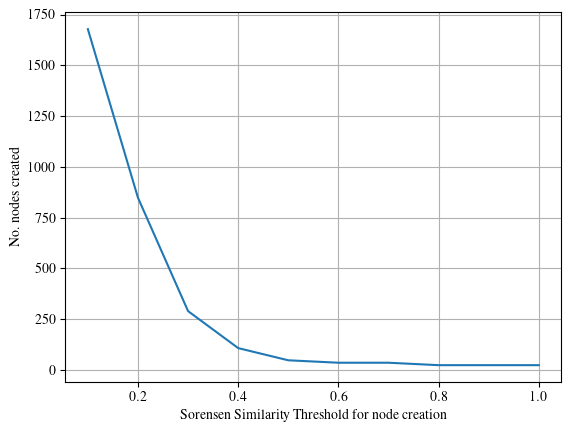

In [102]:

plt.plot([i/10 for i in range(1,11)], no_nodes)
plt.xlabel("Sorensen Similarity Threshold for node creation")
plt.ylabel("No. nodes created")
plt.grid()
plt.savefig("visuals/sorensen_threshold")

## Using the GDS library for python

- documentation https://neo4j.com/docs/graph-data-science-client/current/getting-started/
- Louvain algorithm: https://www.youtube.com/watch?v=0zuiLBOIcsw


### Analysis

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 17.29it/s]


recipients were created:  40
Sorensen-relationships for Data Sharing Network created: 40
25.0% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 14.16it/s]


recipients were created:  51
Sorensen-relationships for Data Sharing Network created: 51
76.47058823529412% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 15.46it/s]


recipients were created:  36
Sorensen-relationships for Data Sharing Network created: 36
80.55555555555556% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 13.47it/s]


recipients were created:  50
Sorensen-relationships for Data Sharing Network created: 50
92.0% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 16.15it/s]


recipients were created:  41
Sorensen-relationships for Data Sharing Network created: 41
90.2439024390244% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 15.81it/s]


recipients were created:  29
Sorensen-relationships for Data Sharing Network created: 29
89.65517241379311% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 15.64it/s]


recipients were created:  43
Sorensen-relationships for Data Sharing Network created: 43
90.69767441860465% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:02<00:00, 17.06it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


recipients were created:  46
Sorensen-relationships for Data Sharing Network created: 46
95.65217391304348% of recipients were in the same cluster
Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 14.95it/s]


recipients were created:  60
Sorensen-relationships for Data Sharing Network created: 60
96.66666666666667% of recipients were in the same cluster


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 16.11it/s]


recipients were created:  51
Sorensen-relationships for Data Sharing Network created: 51
94.11764705882352% of recipients were in the same cluster


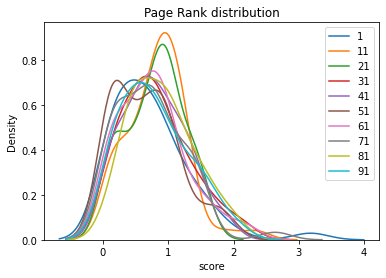

In [7]:
## Some analysis

rd.seed(10)

#set up outcome collectors
community_counts = []
community_dfs = []

recipient_in_cluster = []

#begin the figure
plt.figure()

#iterate through a hyper parameter: here how much do we increase the weight of same cluster nodes for recipient sharing
for prob_scale in range(1,100,10): #add the values to be iterated through

    # make an instance of a database
    fakeTilt = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 50,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 1,
                    cluster_weight = prob_scale,  ### Define the hyperparameter 
                    no_clusters=5,
                    reset=True) #reset has to be true so new graphs are created

    fakeTilt.main() #generate the graph

    recipient_in_cluster.append(fakeTilt.same_cluster[0]/fakeTilt.same_cluster[1])

    try: # get a projection of the graph 
        G,_ = gds.graph.project('prob_scale',
                            ['meta', 
                            #'dataDisclosed', 'tilt', 'recipient'
                                ], 
                            {#'has_meta': {"orientation": "UNDIRECTED"}, 
                            #'has_dataDisclosed': {"orientation": "UNDIRECTED"},
                            #'has_recipient': {"orientation": "UNDIRECTED"}, 
                            'has_dataShared': {"orientation": "UNDIRECTED"}}
                        )
    except: 
        G.drop() # if the projection already exists, delete it and make anew
        G,_ = gds.graph.project('prob_scale',
                            ['meta', 
                            #'dataDisclosed', 'tilt', 'recipient'
                                ], 
                            {#'has_meta': {"orientation": "UNDIRECTED"}, 
                            #'has_dataDisclosed': {"orientation": "UNDIRECTED"},
                            #'has_recipient': {"orientation": "UNDIRECTED"}, 
                            'has_dataShared': {"orientation": "UNDIRECTED"}}
                        )
    
    # run the louvain algorithm. 
    res = gds.louvain.mutate(G, mutateProperty = 'community', nodeLabels = ['meta'], tolerance = 10**(-5))
    
    # get the number of communities found
    community_counts.append(res['communityCount'])

    # collect the number of nodes in each community
    louvain_df = gds.graph.streamNodeProperty(G, 'community')
    community_dfs.append(louvain_df)
    
    #print(gds.graph.streamNodeProperties(G, ['community'], separate_property_columns=True))

    # plot a k-density plot of the page-rank distribution
    sns.kdeplot(gds.pageRank.stream(G)['score'], label = f"{prob_scale}")
    plt.title("Page Rank distribution")
    
    # delete the graph projection
    G.drop()

plt.legend()
plt.show()

In [12]:
print(len(np.unique(louvain_df['propertyValue'])))

9


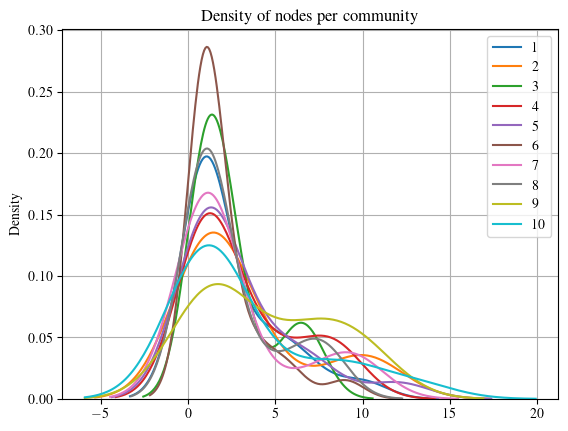

<Figure size 640x480 with 0 Axes>

In [103]:
# plotting the number of community members 
plt.figure()

for it, df in enumerate(community_dfs):

    sns.kdeplot(df.value_counts('propertyValue'), label = f'{it+1}')

plt.title("Density of nodes per community")
plt.legend()
plt.grid()
plt.show()
plt.savefig('visuals/node density per community')

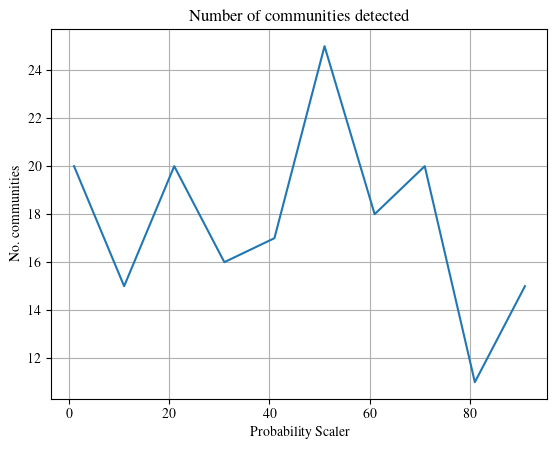

In [104]:
#plotting the number of communities 
plt.plot(range(1,100, 10), community_counts)
plt.title("Number of communities detected")
plt.xlabel("Probability Scaler")
plt.ylabel("No. communities")
plt.grid()
plt.savefig("visuals/no_communities_detected_vs_probability_of_connection")

In [108]:
fakeTilt = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 100,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 1,
                    cluster_weight = 10**8,  ### Define the hyperparameter 
                    no_clusters=5,
                    reset=True) #reset has to be true so new graphs are created

fakeTilt.main() #generate the graph

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/122809291.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 100/100 [00:05<00:00, 17.08it/s]

126 recipients were created: 
Sorensen-relationships for Data Sharing Network created: 126
100.0% of recipients were in the same cluster


## Visuals

Use cypher queries to get an visualualise our database in directly in a jupyter notebook using graphistry

#### Doku
- https://hub.graphistry.com/docs/ui/index/
- https://github.com/graphistry/pygraphistry/blob/master/demos/demos_databases_apis/neo4j/official/graphistry_bolt_tutorial_public.ipynb
- https://hub.graphistry.com/

In [16]:
#!pip install --user graphistry

import graphistry

In [17]:
NEO4J = {
        'uri':'bolt://localhost:11003', 
        'auth' : ('neo4j', 'letmein')
}

graphistry.register(api=3, username='j_halkenhaeusser', password='longlivetransparency22', protocol='https', server='hub.graphistry.com')
graphistry.register(bolt=NEO4J)


In [18]:
graphistry.cypher("""
      match (m:meta)-[s:has_dataShared]-(n:meta), (t:meta) return t, m, s, n
  """).plot()

In [19]:
graphistry.cypher("""
      match (m:meta)-[s:has_dataShared]-(n:meta) return m, s, n
  """).plot()

## Histograms for various graph attributes

In [9]:
gds.graph.list()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema


In [1]:
gds.graph.drop(G = gds.graph.get('make_hist'))

NameError: name 'gds' is not defined

meta    [cluster]
dtype: object


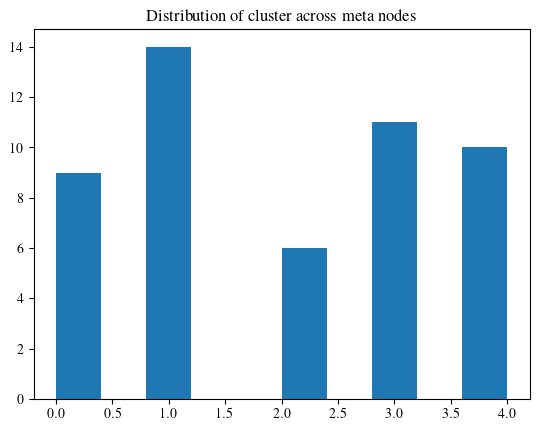

In [10]:
def get_histogram(node_type,
                    attribute, 
                    bolt, 
                    auth,
                    plot_type = 'histogram'): 
    
    gds = GraphDataScience('bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'))

    #make a graph projection (/get all the relevant nodes)
    try: # get a projection of the graph 
        G,_ = gds.graph.project('make_hist',
                    {node_type: {"properties": attribute}}, ### does not work because property is a string???  and it only lets me use strings to create node properties???
                    ['has_dataShared']
                )
    except: 
        G = gds.graph.get('make_hist')
        G.drop()
        G,_ = gds.graph.project('make_hist',
                            {node_type: {"properties": attribute}}, ### does not work because property is a string???  and it only lets me use strings to create node properties???
                            ['has_dataShared']
                        )

    print(G.node_properties())

    # collect the attribute
    property_series = gds.graph.streamNodeProperty(G, attribute)

    if plot_type == 'histogram':

        plt.hist(property_series['propertyValue'])
        plt.title(f"Distribution of {attribute} across {node_type} nodes")

    if plot_type == "density":
        # plot a histogram plot of the page-rank distribution
        sns.kdeplot(gds.pageRank.stream(G)['score'], label = f"{prob_scale}")
        plt.title(f"Distribution of {attribute} across {node_type} nodes")
    

    # delete the graph projection
    G.drop()

    plt.show()


get_histogram("meta", 
            'cluster', 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'))

### Analysing Clusters

In [11]:
fakeTilt = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 50,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 5,
                    cluster_weight = 100,
                    reset=True)
fakeTilt.main()

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 50/50 [00:03<00:00, 13.78it/s]


recipients were created:  257
Sorensen-relationships for Data Sharing Network created: 257
92.60700389105058% of recipients were in the same cluster


In [12]:
G,_ = gds.graph.project('make_hist',
                    {'meta': {"properties": 'cluster'}},
                    ['has_dataShared']
                )

In [13]:
res = gds.louvain.mutate(G, mutateProperty = 'community_default') #,seedProperty = 'cluster', maxIterations=1000, tolerance = 10e-15)

In [14]:
res['communityCount']

5

In [15]:
nodes_communities = gds.graph.streamNodeProperties(G, ['cluster', 'community_default'], separate_property_columns= True)

In [16]:
nodes_communities.groupby(['cluster', 'community_default']).count()

nodeId
cluster community_default        
0       7                       8
1       12                      7
2       43                      2
        44                     13
3       43                     10
4       12                      1
        27                      9

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>, <AxesSubplot:>]], dtype=object)

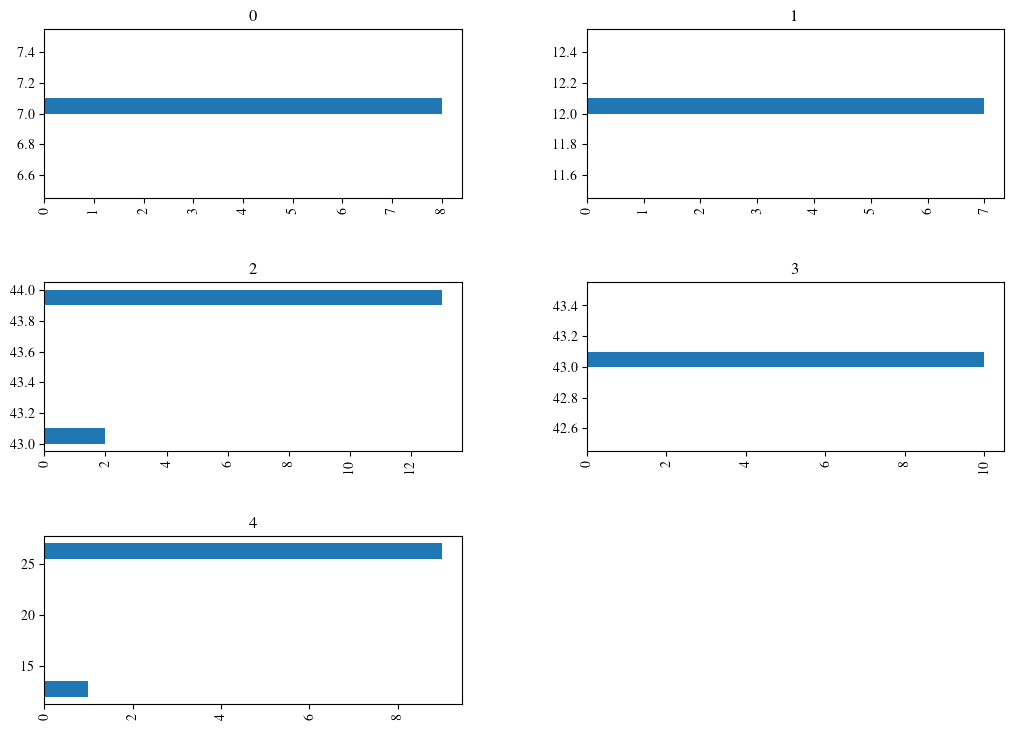

In [109]:
nodes_communities['community_default'].hist(by=nodes_communities['cluster'], orientation= 'horizontal', figsize=(12,9))

In [18]:
gds.graph.drop(gds.graph.get("GDS"))

ValueError: No projected graph named 'GDS' exists in current database 'None'

## Network Dynamics

In [8]:

from re import X


class sim:

    def __init__(self, network_object, no_steps = 10, merge_threshold = 2, exp_mode = False):

        # hyperparameters
        self.no_steps = no_steps
        self.network = network_object
        self.merge_threshold = merge_threshold

        # initialise the network 
        self.network.main()

        # utils
        self.pos = None 
        self.no_nodes_record = []
        self.experiment_mode = exp_mode #surpress visualisation/gif generation for quicker runtime


    def visualise(self, driver, iteration, subtitle):

        # get the connections info 
        curr_dict = pd.DataFrame(driver.run("""
                    MATCH (m: meta)-[c:has_dataShared]->(n: meta)
                    RETURN m.name as source, n.name as target, c.weight as propertyValue, m.cluster as cluster
                """).data())

        G = nx.from_pandas_edgelist(curr_dict, 'source', 'target', 'propertyValue')

        cluster_dict = {'0': 'green',
                        '1': 'blue',
                        '2': 'red',
                        '3': 'orange',
                        '4': 'brown'}

        color_map = []
        
        for n in G.nodes:

            #cluster_dict[n] = {'cluster': self.network.company_df[self.network.company_df['Company'] == n]['cluster'].values[0]}
            color_map.append(cluster_dict[self.network.company_df[self.network.company_df['Company'] == n]['cluster'].values[0]])

        
        nx.set_node_attributes(G, cluster_dict, 'cluster')

        #print(self.pos)
        if self.pos == None: 
            self.pos = nx.spring_layout(G)
            self.fixed_nodes = self.pos.keys()

        it_pos = nx.spring_layout(G, pos=self.pos, fixed = self.fixed_nodes)
            
        nx.draw_networkx(G,pos = it_pos, with_labels = True, font_size = 8, node_color = color_map, edge_color = 'lightgrey')
            
        plt.title(f"Step: {iteration}{subtitle}")

                # in case we don't want to save an image we can just not specify an iteration
        if iteration != None:  
            plt.savefig(f'visuals/{iteration}_network.png')
            plt.close()
        else:
            plt.show() 

    
    def make_gif(self, gifname, ending ='', n_frames = 5):

        """
        func:   creates a gif from pngs. There need to be images saved by the view method.
        input:  length_sim: number of completed runs of simulation
                n_frames: wait time to slow down gif. default = 5.
        output: saves a gif to wd.
        """

        with imageio.get_writer(f'visuals/{gifname}.gif', mode='I') as writer:
            filenames = [f"visuals/{name}{ending}.png" for name in range(self.no_steps)]
            for filename in filenames:
                image = imageio.imread(filename)

                for i in range(n_frames):
                    writer.append_data(image)

        for filename in set(filenames):
            os.remove(filename)

        return

    def new_connection(self, driver, iteration):


        if gds.graph.exists('GDS').exists == True:
                gds.graph.drop(gds.graph.get("GDS"))
                
        driver.run("""   CALL gds.graph.project(
                        'GDS',
                        'meta',  
                        {
                            has_dataShared: {properties: 'weight'}
                        }
                        )
                        YIELD graphName
                """)

        cypher = '''
        CALL gds.pageRank.stream('GDS')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).name AS name,gds.util.asNode(nodeId).cluster AS cluster,  score
        ORDER BY score DESC, name ASC
                '''

        dat = pd.DataFrame(driver.run(cypher).data())

        if not self.experiment_mode:
            plt.hist(dat['score'])
            plt.title(f"Step: {iteration} \n Merge threshold: {self.merge_threshold}")
            plt.xlabel('Page Rank')
            plt.vlines(x = self.merge_threshold, ymin=0, ymax = 10, colors=['red'], linestyles='--')
            plt.savefig(f'visuals/{iteration}_distribution.png')
            plt.close()
        
        if len(dat) == 1:
            return "ONLY ONE NODE LEFT"
        

        start_node = dat.sample(n=1, weights=dat['score'], axis=0)

        # define weights dict
        weights = {}

        # fill with no of clusters 
        for w in range(self.network.no_clusters):
            weights[w] = 1/self.network.no_clusters

        # increase weight for cluster of company
        weights[start_node['cluster'].values[0]] *= self.network.weight_scaler  # more weight on cluster scaler on the connection
        
        # scale the weights
        scaled_weights = (pd.Series(weights) / dat.cluster.value_counts(normalize=True))

        shared_with_comp = start_node['name'].values[0]
        
        while shared_with_comp == start_node['name'].values[0]:
            shared_with_comp = dat.sample(n=1, weights=dat.cluster.map(scaled_weights))['name'].values[0]

        # print(start_node['name'].values[0], shared_with_comp)

        driver.run('''
            MATCH (m:meta {name: %r}), (n:meta {name: %r})
            CREATE (n)-[r:has_dataShared]->(m)
            SET r.weight = .8
        ''' %(start_node['name'].values[0], shared_with_comp))
        
        driver.run("CALL gds.graph.drop('GDS')")
        
        # if the start node has a high page rank merge it with another node (randomness is still granted by nodes with high page rank not always being chosen)
        merge = start_node['score'].values[0] >= self.merge_threshold
        if merge:
            if not self.experiment_mode:
                print("merging:", start_node['name'].values[0], shared_with_comp)
            self.merge_nodes(driver, start_node['name'].values[0], shared_with_comp)
            return f"\n{start_node['name'].values[0]} merged with {shared_with_comp}"

        return ''



    def merge_nodes(self, driver, buyer, seller):

        """ 
        Two nodes merge when 
            - they share more than *hyperparameter* number of connections 
            - picked completely at random. 
            - When a new connection is formed with *hyperparameter*-chance this leads to a merge
            - A node with high page-rank gobbles up a node with low page rank. 

        driver: session driver
        buyer:  node that gets bigger
        seller: deleted node
        """
        
        # get all the connections from the seller node to other nodes
        connection_df_out = pd.DataFrame(driver.run("""
                    MATCH (m: meta {name: %r})-[c:has_dataShared]->(n: meta)
                    RETURN m.name as source, n.name as target, c.weight as propertyValue
                """%(seller)).data())

        # get the connections into the seller from other nodes
        connection_df_in = pd.DataFrame(driver.run("""
            MATCH (m: meta)-[c:has_dataShared]->(n: meta {name: %r})
            RETURN m.name as source, n.name as target, c.weight as propertyValue
        """%(seller)).data())

        # delete the seller node
        driver.run("""
            MATCH (m: meta {name: %r}) DETACH DELETE m;
        """%seller)

        # create connections from the buyer to the target nodes of the seller 
        for index, row in connection_df_out.iterrows():

            if buyer == row['target']:
                continue

            driver.run("""
                MATCH (m:meta {name: %r}), (n:meta {name: %r})
                CREATE (m)-[c:has_dataShared]->(n) 
                SET c.weight = %d 
            """%(buyer, row['target'], row['propertyValue']))

        # create connections into the buyer
        for index, row in connection_df_in.iterrows():
            
            if buyer == row['source']:
                continue

            driver.run("""
                MATCH (m:meta {name: %r}), (n:meta {name: %r})
                CREATE (m)-[c:has_dataShared]->(n) 
                SET c.weight = %d 
            """%(row['source'], buyer, row['propertyValue']))
            

    def main(self):
        
        with self.network.driver.session() as s:

            # delete all recipients.
            s.run("match (d:dataDisclosed), (p:purpose) detach delete d, p")

            if not self.experiment_mode:
                print("Beginning with the simulation.")

            for i in tqdm(range(self.no_steps)):
                
                out = self.new_connection(s, i)
                if not self.experiment_mode:
                    self.visualise(s, i, out)

                self.no_nodes_record.append(s.run("match (m: meta) return COUNT(m)").data()[0]['COUNT(m)'])



            #s.run("CALL gds.graph.drop('GDS')")

            # randomly generate a recipient based on cluster for a random node. 
            # based on some rule determine the probability of the node being chosen (shorter purpose statements are less specific and hence share more or something like that.)
            
            # get two nodes and randomly generate a connection if they are in the same cluster. 

            # when you pass a pagerank of .95 all the recipients of one node get passed to that high pagerank node the node is deleted (i.e. some smaller node merges with a bigger node.)
        
        if not self.experiment_mode:
            self.make_gif('network', ending = '_network')
            self.make_gif('distribution', ending = "_distribution")

        print("Simulation completed. GIF is being generated and can be found in the directory")
        return    

#### Run Network Simulations

Note If there is a strange latex error. Restart the notebook and comment out the rcParams and delete AT&T out of the fortune500 list. 

In [13]:
ntw = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 30,
                    comp_df= fortune_500[fortune_500['Company'] != 'AT&T'].reset_index(),
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 2,
                    cluster_weight = 100,
                    reset=True)


simulation = sim(ntw, 100, exp_mode=False)
simulation.main()

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_31344/122809291.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 30/30 [00:01<00:00, 19.37it/s]


47 recipients were created: 
Sorensen-relationships for Data Sharing Network created: 47
91.48936170212765% of recipients were in the same cluster
Beginning with the simulation.


 70%|███████   | 70/100 [00:47<00:23,  1.26it/s]

merging: Costco Wholesale Cardinal Health


 73%|███████▎  | 73/100 [00:50<00:23,  1.14it/s]

merging: Costco Wholesale Walmart


 77%|███████▋  | 77/100 [00:54<00:24,  1.07s/it]

merging: Costco Wholesale Chevron


 78%|███████▊  | 78/100 [00:57<00:34,  1.55s/it]

merging: McKesson Costco Wholesale


 81%|████████  | 81/100 [01:05<00:40,  2.13s/it]

merging: McKesson Kroger


 82%|████████▏ | 82/100 [01:10<00:53,  2.99s/it]

merging: Ford Motor Exxon Mobil


 86%|████████▌ | 86/100 [01:29<00:58,  4.15s/it]

merging: Ford Motor Meta Platforms


 94%|█████████▍| 94/100 [01:45<00:09,  1.64s/it]

merging: General Motors Ford Motor


 97%|█████████▋| 97/100 [01:49<00:04,  1.39s/it]

merging: McKesson Walgreens Boots Alliance


100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Simulation completed. GIF is being generated and can be found in the directory


/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 30/30 [00:01<00:00, 15.06it/s]


recipients were created:  77
Sorensen-relationships for Data Sharing Network created: 77
92.20779220779221% of recipients were in the same cluster
Beginning with the simulation.


 86%|████████▌ | 86/100 [00:27<00:04,  3.47it/s]

merging: Meta Platforms McKesson


 91%|█████████ | 91/100 [00:29<00:03,  2.87it/s]

merging: Meta Platforms JPMorgan Chase


 95%|█████████▌| 95/100 [00:31<00:02,  2.40it/s]

merging: Meta Platforms Chevron


 97%|█████████▋| 97/100 [00:32<00:01,  2.51it/s]

merging: Home Depot AT&T


 99%|█████████▉| 99/100 [00:33<00:00,  2.59it/s]

merging: Meta Platforms Marathon Petroleum


100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


Simulation completed. GIF is being generated and can be found in the directory


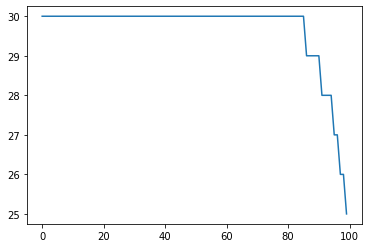

In [88]:
ntw = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 30,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 2,
                    cluster_weight = 100,
                    reset=True)


simulation = sim(ntw, 100)
simulation.main()

plt.plot(range(100),simulation.no_nodes_record)

/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Graph has been cleared


100%|██████████| 30/30 [00:01<00:00, 16.57it/s]


recipients were created:  50
Sorensen-relationships for Data Sharing Network created: 50
92.0% of recipients were in the same cluster


100%|██████████| 100/100 [00:20<00:00,  4.78it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Simulation completed. GIF is being generated and can be found in the directory
Graph has been cleared


100%|██████████| 30/30 [00:01<00:00, 15.70it/s]


recipients were created:  72
Sorensen-relationships for Data Sharing Network created: 72
87.5% of recipients were in the same cluster


100%|██████████| 100/100 [00:27<00:00,  3.58it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Simulation completed. GIF is being generated and can be found in the directory
Graph has been cleared


100%|██████████| 30/30 [00:02<00:00, 13.13it/s]


recipients were created:  75
Sorensen-relationships for Data Sharing Network created: 75
96.0% of recipients were in the same cluster


100%|██████████| 100/100 [00:26<00:00,  3.71it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Simulation completed. GIF is being generated and can be found in the directory
Graph has been cleared


100%|██████████| 30/30 [00:01<00:00, 18.66it/s]


recipients were created:  42
Sorensen-relationships for Data Sharing Network created: 42
90.47619047619048% of recipients were in the same cluster


100%|██████████| 100/100 [00:24<00:00,  4.06it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Simulation completed. GIF is being generated and can be found in the directory
Graph has been cleared


100%|██████████| 30/30 [00:02<00:00, 13.25it/s]


recipients were created:  62
Sorensen-relationships for Data Sharing Network created: 62
91.93548387096774% of recipients were in the same cluster


100%|██████████| 100/100 [00:29<00:00,  3.40it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Simulation completed. GIF is being generated and can be found in the directory
Graph has been cleared


100%|██████████| 30/30 [00:02<00:00, 14.59it/s]


recipients were created:  53
Sorensen-relationships for Data Sharing Network created: 53
86.79245283018868% of recipients were in the same cluster


100%|██████████| 100/100 [00:33<00:00,  2.97it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Simulation completed. GIF is being generated and can be found in the directory
Graph has been cleared


100%|██████████| 30/30 [00:02<00:00, 13.68it/s]


recipients were created:  59
Sorensen-relationships for Data Sharing Network created: 59
88.13559322033898% of recipients were in the same cluster


100%|██████████| 100/100 [00:32<00:00,  3.12it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Simulation completed. GIF is being generated and can be found in the directory
Graph has been cleared


100%|██████████| 30/30 [00:02<00:00, 14.71it/s]


recipients were created:  63
Sorensen-relationships for Data Sharing Network created: 63
82.53968253968253% of recipients were in the same cluster


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Simulation completed. GIF is being generated and can be found in the directory
Graph has been cleared


100%|██████████| 30/30 [00:02<00:00, 13.22it/s]


recipients were created:  63
Sorensen-relationships for Data Sharing Network created: 63
92.06349206349206% of recipients were in the same cluster


100%|██████████| 100/100 [00:17<00:00,  5.82it/s]
/var/folders/zb/r42lnkhn1vjgbg6gmbnqxz6h0000gn/T/ipykernel_10178/1236196302.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.company_df['cluster'] = [str(rd.randrange(no_clusters)) for _ in range(len(self.company_df))]


Simulation completed. GIF is being generated and can be found in the directory
Graph has been cleared


100%|██████████| 30/30 [00:01<00:00, 16.34it/s]


recipients were created:  56
Sorensen-relationships for Data Sharing Network created: 56
91.07142857142857% of recipients were in the same cluster


100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Simulation completed. GIF is being generated and can be found in the directory


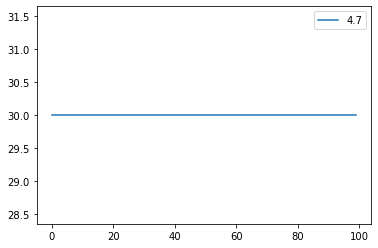

In [89]:
exp=[]
for i in range(2,50,5):

    ntw = exampleTilt(uri = 'bolt://localhost:11003', 
                    auth = ('neo4j', 'letmein'), 
                    no_nodes= 30,
                    comp_df= fortune_500,
                    category_list = categories, 
                    purpose_list = purpose,
                    mu_poisson_dataDisclosed = 1,
                    mu_poisson_recipients= 2,
                    cluster_weight = 100,
                    reset=True)


    simulation = sim(ntw, 100, merge_threshold=i/10, exp_mode=True)
    simulation.main()
    exp.append(simulation.no_nodes_record)
    plt.plot(range(100),simulation.no_nodes_record, label = i/10)

plt.legend()
plt.show()


In [91]:
len(exp)

10

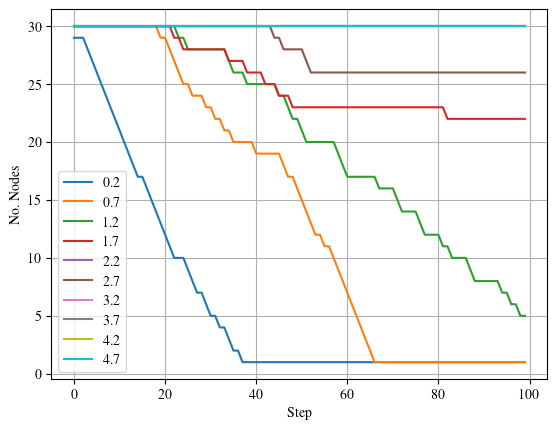

In [110]:
for i, it in enumerate(range(2,50,5)):
    plt.plot(range(100),exp[i], label = it/10)
plt.grid()
plt.xlabel("Step")
plt.ylabel("No. Nodes")
plt.legend()
plt.savefig("visuals/node_count_by_pageRankThreshold")